In [210]:
#https://www.kaggle.com/oysiyl/good-fun-with-ligthgbm score roc_auc = .779 but .783 in own kernel
# my score is .776
import pandas as pd
import numpy as np
from scipy import sparse as ssp
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.model_selection import StratifiedKFold, cross_val_score
import lightgbm as lgbm
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute, MICE
from lightgbm import LGBMClassifier
gc.enable()

In [78]:
def Gini(y_true, y_pred):
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]

    # sort rows on prediction column
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:, 0].argsort()][::-1, 0]
    pred_order = arr[arr[:, 1].argsort()][::-1, 0]

    # get Lorenz curves
    L_true = np.cumsum(true_order) * 1. / np.sum(true_order)
    L_pred = np.cumsum(pred_order) * 1. / np.sum(pred_order)
    L_ones = np.linspace(1 / n_samples, 1, n_samples)

    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)

    # normalize to true Gini coefficient
    return G_pred * 1. / G_true

def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', Gini(labels, preds), True

In [79]:
buro_bal = pd.read_csv('data/bureau_balance.csv')
print('Buro bal shape : ', buro_bal.shape)

print('transform to dummies')
buro_bal = pd.concat([buro_bal, pd.get_dummies(buro_bal.STATUS, prefix='buro_bal_status')], axis=1).drop('STATUS', axis=1)

print('Counting buros')
buro_counts = buro_bal[['SK_ID_BUREAU', 'MONTHS_BALANCE']].groupby('SK_ID_BUREAU').count()
buro_bal['buro_count'] = buro_bal['SK_ID_BUREAU'].map(buro_counts['MONTHS_BALANCE'])
buro_bal.head()

('Buro bal shape : ', (27299925, 3))
transform to dummies
Counting buros


,SK_ID_BUREAU,MONTHS_BALANCE,buro_bal_status_0,buro_bal_status_1,buro_bal_status_2,buro_bal_status_3,buro_bal_status_4,buro_bal_status_5,buro_bal_status_C,buro_bal_status_X,buro_count
0,5715448,0,0,0,0,0,0,0,1,0,27
1,5715448,-1,0,0,0,0,0,0,1,0,27
2,5715448,-2,0,0,0,0,0,0,1,0,27
3,5715448,-3,0,0,0,0,0,0,1,0,27
4,5715448,-4,0,0,0,0,0,0,1,0,27


In [80]:
print('averaging buro bal')
avg_buro_bal = buro_bal.groupby('SK_ID_BUREAU').mean()

avg_buro_bal.columns = ['avg_buro_' + f_ for f_ in avg_buro_bal.columns]
del buro_bal
gc.collect()


averaging buro bal


393

In [81]:
avg_buro_bal.head()

,avg_buro_MONTHS_BALANCE,avg_buro_buro_bal_status_0,avg_buro_buro_bal_status_1,avg_buro_buro_bal_status_2,avg_buro_buro_bal_status_3,avg_buro_buro_bal_status_4,avg_buro_buro_bal_status_5,avg_buro_buro_bal_status_C,avg_buro_buro_bal_status_X,avg_buro_buro_count
SK_ID_BUREAU,,,,,,,,,,
5001709,-48.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.886598,0.113402,97.0
5001710,-41.0,0.060241,0.0,0.0,0.0,0.0,0.0,0.578313,0.361446,83.0
5001711,-1.5,0.750000,0.0,0.0,0.0,0.0,0.0,0.000000,0.250000,4.0
5001712,-9.0,0.526316,0.0,0.0,0.0,0.0,0.0,0.473684,0.000000,19.0
5001713,-10.5,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,22.0


In [82]:
print('Read Bureau')
buro = pd.read_csv('data/bureau.csv')

print('Go to dummies')
buro_credit_active_dum = pd.get_dummies(buro.CREDIT_ACTIVE, prefix='ca_')
buro_credit_currency_dum = pd.get_dummies(buro.CREDIT_CURRENCY, prefix='cu_')
buro_credit_type_dum = pd.get_dummies(buro.CREDIT_TYPE, prefix='ty_')

buro_full = pd.concat([buro, buro_credit_active_dum, buro_credit_currency_dum, buro_credit_type_dum], axis=1)
# buro_full.columns = ['buro_' + f_ for f_ in buro_full.columns]

del buro_credit_active_dum, buro_credit_currency_dum, buro_credit_type_dum
gc.collect()
buro_full.head()

Read Bureau
Go to dummies


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,...,ty__Interbank credit,ty__Loan for business development,ty__Loan for purchase of shares (margin lending),ty__Loan for the purchase of equipment,ty__Loan for working capital replenishment,ty__Microloan,ty__Mobile operator loan,ty__Mortgage,ty__Real estate loan,ty__Unknown type of loan
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,...,0,0,0,0,0,0,0,0,0,0
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,0
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,0
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,0
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
print('Merge with buro avg')
buro_full = buro_full.merge(right=avg_buro_bal.reset_index(), how='left', on='SK_ID_BUREAU', suffixes=('', '_bur_bal'))

print('Counting buro per SK_ID_CURR')
nb_bureau_per_curr = buro_full[['SK_ID_CURR', 'SK_ID_BUREAU']].groupby('SK_ID_CURR').count()
buro_full['SK_ID_BUREAU'] = buro_full['SK_ID_CURR'].map(nb_bureau_per_curr['SK_ID_BUREAU'])

print('Averaging bureau')
avg_buro = buro_full.groupby('SK_ID_CURR').mean()
print(avg_buro.head())

Merge with buro avg
Counting buro per SK_ID_CURR
Averaging bureau
            SK_ID_BUREAU  DAYS_CREDIT  CREDIT_DAY_OVERDUE  \
SK_ID_CURR                                                  
100001               7.0  -735.000000                 0.0   
100002               8.0  -874.000000                 0.0   
100003               4.0 -1400.750000                 0.0   
100004               2.0  -867.000000                 0.0   
100005               3.0  -190.666667                 0.0   

            DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
SK_ID_CURR                                                                   
100001                82.428571        -825.500000                     NaN   
100002              -349.000000        -697.500000                1681.029   
100003              -544.500000       -1097.333333                   0.000   
100004              -488.500000        -532.500000                   0.000   
100005               439.333333       

In [84]:
del buro, buro_full
gc.collect()
print('Read prev')
prev = pd.read_csv('data/previous_application.csv')

prev_cat_features = [
    f_ for f_ in prev.columns if prev[f_].dtype == 'object'
]

print('Go to dummies')
prev_dum = pd.DataFrame()
for f_ in prev_cat_features:
    prev_dum = pd.concat([prev_dum, pd.get_dummies(prev[f_], prefix=f_).astype(np.uint8)], axis=1)

prev = pd.concat([prev, prev_dum], axis=1)

del prev_dum
gc.collect()
prev.head()

Read prev
Go to dummies


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,0,0,0,0,0,0,1,0,0,0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,1,0,0,0,0,0,0,0,0,0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,0,0,0,0,0,0,0,0,0,0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,0,1,0,0,0,0,0,0,0,0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,0,0,0,0,0,0,0,0,0,0


In [85]:
print('Counting number of Prevs')
nb_prev_per_curr = prev[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
prev['SK_ID_PREV'] = prev['SK_ID_CURR'].map(nb_prev_per_curr['SK_ID_PREV'])

print('Averaging prev')
avg_prev = prev.groupby('SK_ID_CURR').mean()
print(avg_prev.head())
del prev
gc.collect()

Counting number of Prevs
Averaging prev
            SK_ID_PREV  AMT_ANNUITY  AMT_APPLICATION  AMT_CREDIT  \
SK_ID_CURR                                                         
100001             1.0     3951.000         24835.50    23787.00   
100002             1.0     9251.775        179055.00   179055.00   
100003             3.0    56553.990        435436.50   484191.00   
100004             1.0     5357.250         24282.00    20106.00   
100005             2.0     4813.200         22308.75    20076.75   

            AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                               
100001                2520.0          24835.5                13.000000   
100002                   0.0         179055.0                 9.000000   
100003                3442.5         435436.5                14.666667   
100004                4860.0          24282.0                 5.000000   
100005                4464.0          4

632

In [86]:
print('Reading POS_CASH')
pos = pd.read_csv('data/POS_CASH_balance.csv')

print('Go to dummies')
pos = pd.concat([pos, pd.get_dummies(pos['NAME_CONTRACT_STATUS'])], axis=1)

print('Compute nb of prevs per curr')
nb_prevs = pos[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
pos['SK_ID_PREV'] = pos['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])

print('Go to averages')
avg_pos = pos.groupby('SK_ID_CURR').mean()

del pos, nb_prevs
gc.collect()
avg_pos.head()

Reading POS_CASH
Go to dummies
Compute nb of prevs per curr
Go to averages


,SK_ID_PREV,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF,Active,Amortized debt,Approved,Canceled,Completed,Demand,Returned to the store,Signed,XNA
SK_ID_CURR,,,,,,,,,,,,,,,
100001,9.0,-72.555556,4.000000,1.444444,0.777778,0.777778,0.777778,0.0,0.0,0.0,0.222222,0.0,0.0,0.000000,0.0
100002,19.0,-10.000000,24.000000,15.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
100003,28.0,-43.785714,10.107143,5.785714,0.000000,0.000000,0.928571,0.0,0.0,0.0,0.071429,0.0,0.0,0.000000,0.0
100004,4.0,-25.500000,3.750000,2.250000,0.000000,0.000000,0.750000,0.0,0.0,0.0,0.250000,0.0,0.0,0.000000,0.0
100005,11.0,-20.000000,11.700000,7.200000,0.000000,0.000000,0.818182,0.0,0.0,0.0,0.090909,0.0,0.0,0.090909,0.0


In [87]:
print('Reading CC balance')
cc_bal = pd.read_csv('data/credit_card_balance.csv')

print('Go to dummies')
cc_bal = pd.concat([cc_bal, pd.get_dummies(cc_bal['NAME_CONTRACT_STATUS'], prefix='cc_bal_status_')], axis=1)

nb_prevs = cc_bal[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
cc_bal['SK_ID_PREV'] = cc_bal['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])

print('Compute average')
avg_cc_bal = cc_bal.groupby('SK_ID_CURR').mean()
avg_cc_bal.columns = ['cc_bal_' + f_ for f_ in avg_cc_bal.columns]

del cc_bal, nb_prevs
gc.collect()
avg_cc_bal.head()

Reading CC balance
Go to dummies
Compute average


,cc_bal_SK_ID_PREV,cc_bal_MONTHS_BALANCE,cc_bal_AMT_BALANCE,cc_bal_AMT_CREDIT_LIMIT_ACTUAL,cc_bal_AMT_DRAWINGS_ATM_CURRENT,cc_bal_AMT_DRAWINGS_CURRENT,cc_bal_AMT_DRAWINGS_OTHER_CURRENT,cc_bal_AMT_DRAWINGS_POS_CURRENT,cc_bal_AMT_INST_MIN_REGULARITY,cc_bal_AMT_PAYMENT_CURRENT,...,cc_bal_CNT_INSTALMENT_MATURE_CUM,cc_bal_SK_DPD,cc_bal_SK_DPD_DEF,cc_bal_cc_bal_status__Active,cc_bal_cc_bal_status__Approved,cc_bal_cc_bal_status__Completed,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent proposal,cc_bal_cc_bal_status__Signed
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,6.0,-3.5,0.000000,270000.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,...,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
100011,74.0,-38.5,54482.111149,164189.189189,2432.432432,2432.432432,0.0,0.0,3956.221849,4843.064189,...,25.767123,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
100013,96.0,-48.5,18159.919219,131718.750000,6350.000000,5953.125000,0.0,0.0,1454.539551,7168.346250,...,18.719101,0.010417,0.010417,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
100021,17.0,-10.0,0.000000,675000.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,...,0.000000,0.000000,0.000000,0.411765,0.0,0.588235,0.0,0.0,0.0,0.0
100023,8.0,-7.5,0.000000,135000.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,...,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [88]:
print('Reading Installments')
inst = pd.read_csv('data/installments_payments.csv')
nb_prevs = inst[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
inst['SK_ID_PREV'] = inst['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])

avg_inst = inst.groupby('SK_ID_CURR').mean()
avg_inst.columns = ['inst_' + f_ for f_ in avg_inst.columns]

print('Read data and test')
data = pd.read_csv('data/application_train.csv')
test = pd.read_csv('data/application_test.csv')
print('Shapes : ', data.shape, test.shape)

y = data['TARGET']
del data['TARGET']
avg_inst.head()

Reading Installments
Read data and test
('Shapes : ', (307511, 122), (48744, 121))


,inst_SK_ID_PREV,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
SK_ID_CURR,,,,,,,
100001,7.0,1.142857,2.714286,-2187.714286,-2195.000000,5885.132143,5885.132143
100002,19.0,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105
100003,25.0,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000
100004,3.0,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000
100005,9.0,1.111111,5.000000,-586.000000,-609.555556,6240.205000,6240.205000


In [89]:
categorical_feats = [
    f for f in data.columns if data[f].dtype == 'object'
]
categorical_feats
for f_ in categorical_feats:
    data[f_], indexer = pd.factorize(data[f_])
    test[f_] = indexer.get_indexer(test[f_])
    
data = data.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(right=avg_pos.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_pos.reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')

del avg_buro, avg_prev
gc.collect()

print data.shape
data.head()

(307511, 380)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,...,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent proposal,cc_bal_cc_bal_status__Signed,inst_SK_ID_PREV,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
0,100002,0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,19.0,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,25.0,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000
2,100004,1,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,3.0,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000
3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,16.0,1.125000,4.437500,-252.250000,-271.625000,62947.088438,62947.088438
4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,66.0,1.166667,7.045455,-1028.606061,-1032.242424,12666.444545,12214.060227


In [103]:
data.describe()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,...,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent proposal,cc_bal_cc_bal_status__Signed,inst_SK_ID_PREV,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,...,86905.000000,86905.000000,86905.000000,291643.000000,291643.000000,291643.000000,291643.000000,291635.000000,2.916430e+05,2.916350e+05
mean,278180.518577,0.095213,0.658370,0.340108,0.306327,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,...,0.000002,0.000064,0.003738,39.745826,1.041501,9.764795,-909.662335,-920.961181,1.839261e+04,1.875431e+04
std,102790.175348,0.293509,0.474284,0.473746,0.460968,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,...,0.000155,0.000877,0.031882,40.738723,0.602107,11.273675,598.461681,597.024650,2.333797e+04,2.510536e+04
min,100002.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,-2922.000000,-3071.000000,0.000000e+00,1.890000e-01
25%,189145.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,...,0.000000,0.000000,0.000000,12.000000,1.000000,4.555556,-1301.959806,-1311.842195,7.799513e+03,7.478370e+03
50%,278202.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,...,0.000000,0.000000,0.000000,25.000000,1.017241,6.045455,-795.953488,-807.581818,1.257265e+04,1.222576e+04
75%,367142.500000,0.000000,1.000000,1.000000,1.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,...,0.000000,0.000000,0.000000,51.000000,1.111111,9.434413,-419.000000,-431.609963,2.137614e+04,2.135286e+04
max,456255.000000,1.000000,2.000000,1.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,...,0.013889,0.024390,1.000000,372.000000,39.000000,138.110063,-3.000000,-3.000000,2.504590e+06,2.504590e+06


In [102]:
missing_df=data.isnull().sum().sort_values(ascending=True)
missing_df=pd.DataFrame(missing_df)
missing_df.columns=['sum_missing']
missing_df[missing_df.sum_missing!=0].describe()

,sum_missing
count,320.000000
mean,70285.734375
std,82951.972758
min,1.000000
25%,16454.000000
50%,16454.000000
75%,153020.000000
max,302902.000000


In [116]:
# impute some missing data
impute_cols=missing_df[missing_df.sum_missing<=16454].index
X_solv = data[impute_cols].iloc[:,1:]
X_cols=list(X_solv)

solver=MICE()
X_solv=pd.DataFrame(solver.complete(X_solv.values))


[MICE] Completing matrix with shape (307511, 225)
[MICE] Starting imputation round 1/110, elapsed time 1.125
[MICE] Starting imputation round 2/110, elapsed time 470.980
[MICE] Starting imputation round 3/110, elapsed time 933.796
[MICE] Starting imputation round 4/110, elapsed time 1395.730
[MICE] Starting imputation round 5/110, elapsed time 1855.102
[MICE] Starting imputation round 6/110, elapsed time 2314.668
[MICE] Starting imputation round 7/110, elapsed time 2776.220
[MICE] Starting imputation round 8/110, elapsed time 3238.056
[MICE] Starting imputation round 9/110, elapsed time 3699.477
[MICE] Starting imputation round 10/110, elapsed time 4161.877
[MICE] Starting imputation round 11/110, elapsed time 4632.394
[MICE] Starting imputation round 12/110, elapsed time 5090.825
[MICE] Starting imputation round 13/110, elapsed time 5550.263
[MICE] Starting imputation round 14/110, elapsed time 6011.456
[MICE] Starting imputation round 15/110, elapsed time 6462.769
[MICE] Starting imp

ValueError: Length mismatch: Expected axis has 225 elements, new values have 307511 elements

In [121]:
X_solv.columns=impute_cols[1:]
X_solv.head()


,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,HOUSETYPE_MODE,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FLAG_DOCUMENT_21,FLAG_DOCUMENT_20,FLAG_DOCUMENT_19,FLAG_DOCUMENT_18,...,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,FLAG_LAST_APPL_PER_CONTRACT_N,FLAG_LAST_APPL_PER_CONTRACT_Y,NAME_CASH_LOAN_PURPOSE_Building a house or an annex,WEEKDAY_APPR_PROCESS_START_FRIDAY,DAYS_DECISION
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,0.000000,-606.000000
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.333333,0.333333,0.000000,0.000000,0.0,0.0,1.0,0.0,0.333333,-1305.000000
2,0.0,0.0,0.0,-1.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,1.000000,-815.000000
3,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.111111,0.111111,0.666667,0.111111,0.0,0.0,1.0,0.0,0.000000,-272.444444
4,0.0,0.0,0.0,-1.0,1.0,3.0,0.0,0.0,0.0,0.0,...,0.166667,0.333333,0.166667,0.000000,0.0,0.0,1.0,0.0,0.166667,-1222.833333


In [124]:
missing_test=test.isnull().sum().sort_values(ascending=True)
missing_test=pd.DataFrame(missing_test)
missing_test.columns=['sum_missing']
missing_test[missing_test.sum_missing!=0].describe()

,sum_missing
count,317.000000
mean,8895.643533
std,12448.096953
min,8.000000
25%,944.000000
50%,944.000000
75%,8668.000000
max,47632.000000


In [126]:
# impute some missing data
impute_cols_test=missing_test[missing_test.sum_missing<=8668].index
test_solv = test[impute_cols_test].iloc[:,1:]
test_cols=list(test_solv)

solver=MICE()
test_solv=pd.DataFrame(solver.complete(test_solv.values))

[MICE] Completing matrix with shape (48744, 300)
[MICE] Starting imputation round 1/110, elapsed time 0.146
[MICE] Starting imputation round 2/110, elapsed time 80.508
[MICE] Starting imputation round 3/110, elapsed time 156.753
[MICE] Starting imputation round 4/110, elapsed time 231.858
[MICE] Starting imputation round 5/110, elapsed time 306.909
[MICE] Starting imputation round 6/110, elapsed time 382.173
[MICE] Starting imputation round 7/110, elapsed time 457.579
[MICE] Starting imputation round 8/110, elapsed time 533.111
[MICE] Starting imputation round 9/110, elapsed time 614.730
[MICE] Starting imputation round 10/110, elapsed time 698.591
[MICE] Starting imputation round 11/110, elapsed time 776.142
[MICE] Starting imputation round 12/110, elapsed time 851.206
[MICE] Starting imputation round 13/110, elapsed time 929.354
[MICE] Starting imputation round 14/110, elapsed time 1016.579
[MICE] Starting imputation round 15/110, elapsed time 1112.177
[MICE] Starting imputation roun

In [186]:
test_solv.columns=test_cols

In [190]:
# replace columns with imputed
for col in list(test_solv):
    test[col]=test_solv[col]
for col in list(X_solv):
    data[col]=X_solv[col]
    

In [192]:
# turns sparse matrix to Compressed Sparse Row format
X = data.iloc[:,1:]#.values
X_test = test.iloc[:,1:]#.values #X_test is unknown X

train_label = y

In [198]:
#some how lost what y was equal to
target_retrace = pd.read_csv('data/application_train.csv')
y=target_retrace['TARGET']

Training until validation scores don't improve for 300 rounds.
[100]	training's auc: 0.764353	valid_1's auc: 0.741433
[200]	training's auc: 0.792315	valid_1's auc: 0.760961
[300]	training's auc: 0.810101	valid_1's auc: 0.768997
[400]	training's auc: 0.823811	valid_1's auc: 0.772174
[500]	training's auc: 0.835752	valid_1's auc: 0.773535
[600]	training's auc: 0.846556	valid_1's auc: 0.77442
[700]	training's auc: 0.856657	valid_1's auc: 0.774809
[800]	training's auc: 0.865372	valid_1's auc: 0.775242
[900]	training's auc: 0.874024	valid_1's auc: 0.775339
[1000]	training's auc: 0.882353	valid_1's auc: 0.775749
[1100]	training's auc: 0.890172	valid_1's auc: 0.77586
[1200]	training's auc: 0.89712	valid_1's auc: 0.775786
[1300]	training's auc: 0.903633	valid_1's auc: 0.775814
[1400]	training's auc: 0.909708	valid_1's auc: 0.775674
Early stopping, best iteration is:
[1113]	training's auc: 0.891141	valid_1's auc: 0.775927
Fold  1 AUC : 0.775927
Training until validation scores don't improve for 

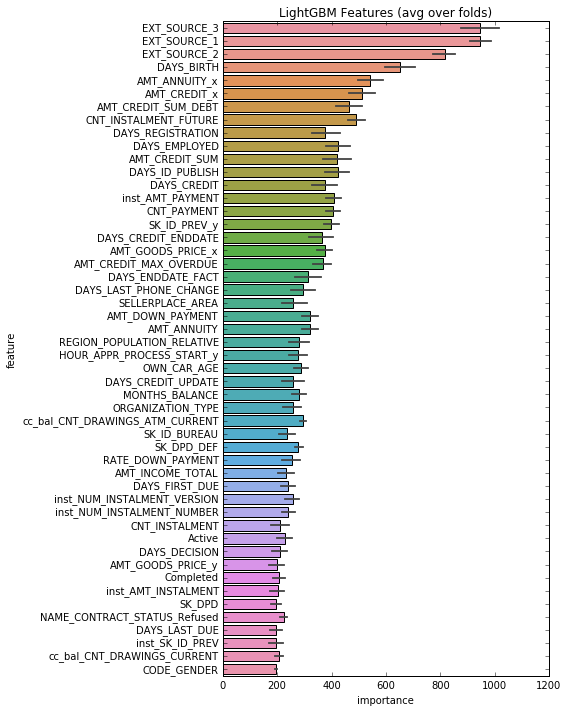

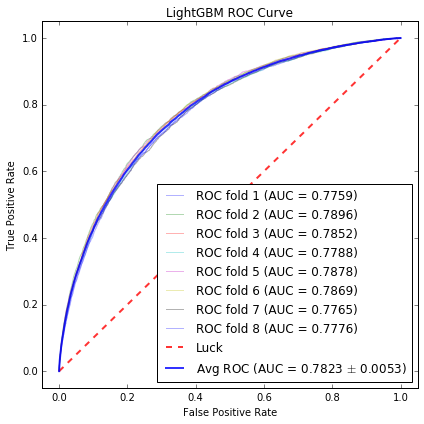

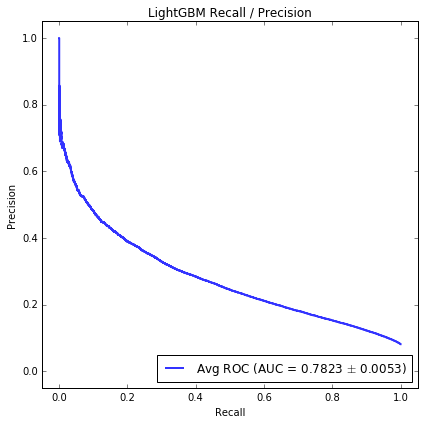

In [211]:
folds = KFold(n_splits=8, shuffle=True, random_state=546789)
oof_preds = np.zeros(data.shape[0])
sub_preds = np.zeros(test.shape[0]) #sub for submission

feature_importance_df = pd.DataFrame()

feats = [f for f in data.columns if f not in ['SK_ID_CURR']]

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(data)):
    trn_x, trn_y = data[feats].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = data[feats].iloc[val_idx], y.iloc[val_idx]
    
    clf = LGBMClassifier(
        # n_estimators=1000,
        # num_leaves=20,
        # colsample_bytree=.8,
        # subsample=.8,
        # max_depth=7,
        # reg_alpha=.1,
        # reg_lambda=.1,
        # min_split_gain=.01
        n_estimators=10000,
        learning_rate=0.03,
        num_leaves=30,
        colsample_bytree=.8,
        subsample=.9,
        #max_depth=8,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
    )
    
    clf.fit(trn_x, trn_y, 
            eval_set= [(trn_x, trn_y), (val_x, val_y)], 
            eval_metric='auc', verbose=100, early_stopping_rounds=300  #30
           )
    
    oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
    del clf, trn_x, trn_y, val_x, val_y
    gc.collect()
    
print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 

test['TARGET'] = sub_preds

test[['SK_ID_CURR', 'TARGET']].to_csv('first_submission.csv', index=False)

# Plot feature importances
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(8,10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

# Plot ROC curves
plt.figure(figsize=(6,6))
scores = [] 
for n_fold, (_, val_idx) in enumerate(folds.split(data)):  
    # Plot the roc curve
    fpr, tpr, thresholds = roc_curve(y.iloc[val_idx], oof_preds[val_idx])
    score = roc_auc_score(y.iloc[val_idx], oof_preds[val_idx])
    scores.append(score)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (n_fold + 1, score))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)
fpr, tpr, thresholds = roc_curve(y, oof_preds)
score = roc_auc_score(y, oof_preds)
plt.plot(fpr, tpr, color='b',
         label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
         lw=2, alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LightGBM ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()

plt.savefig('roc_curve.png')

# Plot ROC curves
plt.figure(figsize=(6,6))
precision, recall, thresholds = precision_recall_curve(y, oof_preds)
score = roc_auc_score(y, oof_preds)
plt.plot(recall, precision, color='b',
         label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
         lw=2, alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('LightGBM Recall / Precision')
plt.legend(loc="lower right")
plt.tight_layout()

plt.savefig('recall_precision_curve.png')

In [208]:
train_label = y
test_id = test['SK_ID_CURR']

cv_only = True
save_cv = True
full_train = False
num_boost_round = 10000

params = {"objective": "binary",
          'n_estimators':10000,
        'learning_rate':0.03,
        'num_leaves':30,
        'colsample_bytree':.8,
        'subsample':.9,
        #max_depth:8,
        'reg_alpha':.1,
        'reg_lambda':.1,
        'min_split_gain':.01,
        'min_child_weight':2,
        'silent':-1,
        'verbose':-1}

x_score = []
final_cv_train = np.zeros(len(train_label))
final_cv_pred = np.zeros(len(test_id))

NFOLDS = 8
kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=218)

range_n=20
for s in xrange(range_n):
    
    #NFOLDS = 5
    #kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=s) # i chose to randomize splits
    
    cv_train = np.zeros(len(train_label))
    cv_pred = np.zeros(len(test_id))

    params['seed'] = s

    if cv_only:
        kf = kfold.split(X, train_label) #split randomly

        best_trees = []
        fold_scores = []

        for i, (train_fold, validate) in enumerate(kf): #split into 3 crossfolds
            X_train, X_validate, label_train, label_validate = \
                X[train_fold, :], X[validate, :], train_label[train_fold], train_label[validate]
            dtrain = lgbm.Dataset(X_train, label_train)
            dvalid = lgbm.Dataset(X_validate, label_validate, reference=dtrain)
            bst = lgbm.train(params, dtrain, num_boost_round, valid_sets=dvalid, feval=evalerror, verbose_eval=100,
                            early_stopping_rounds=300) # best iteration?? = best number of trees?
            best_trees.append(bst.best_iteration)
            cv_pred += bst.predict(X_test, num_iteration=bst.best_iteration) # set best_iteration as number of trees?
            cv_train[validate] += bst.predict(X_validate) #predict validation set

            score = Gini(label_validate, cv_train[validate])
            print score
            fold_scores.append(score)

        cv_pred /= NFOLDS
        final_cv_train += cv_train
        final_cv_pred += cv_pred

        print("cv score:")
        print Gini(train_label, cv_train)
        print "current score:", Gini(train_label, final_cv_train / (s + 1.)), s+1
        print(fold_scores)
        print(best_trees, np.mean(best_trees))

        x_score.append(Gini(train_label, cv_train))

print(x_score) #.556 to beat

TypeError: unhashable type: 'numpy.ndarray'

In [212]:
pd.read_csv('first_submission.csv').head()

,SK_ID_CURR,TARGET
0,100001,0.029881
1,100005,0.133973
2,100013,0.019067
3,100028,0.040309
4,100038,0.155504


In [207]:
kf = kfold.split(X, train_label)
kf

<generator object split at 0x1249035a0>

In [204]:
for s in xrange(16):
    cv_train = np.zeros(len(train_label))
    cv_pred = np.zeros(len(test_id))

    params['seed'] = s

    if cv_only:
        kf = kfold.split(X, train_label) #split randomly

        best_trees = []
        fold_scores = []

        for i, (train_fold, validate) in enumerate(kf): #split into 3 crossfolds
            X_train, X_validate, label_train, label_validate = \
                X[train_fold, :], X[validate, :], train_label[train_fold], train_label[validate] #for each crossfold
            dtrain = lgbm.Dataset(X_train, label_train)
            dvalid = lgbm.Dataset(X_validate, label_validate, reference=dtrain)
            bst = lgbm.train(params, dtrain, num_boost_round, valid_sets=dvalid, feval=evalerror, verbose_eval=100,
                            early_stopping_rounds=100) # best iteration?? = best number of trees?
            best_trees.append(bst.best_iteration)
            cv_pred += bst.predict(X_test, num_iteration=bst.best_iteration) # set best_iteration as number of trees?
            cv_train[validate] += bst.predict(X_validate) #predict validation set

            score = Gini(label_validate, cv_train[validate])
            print score
            fold_scores.append(score)

        cv_pred /= NFOLDS
        final_cv_train += cv_train
        final_cv_pred += cv_pred

        print("cv score:")
        print Gini(train_label, cv_train)
        print "current score:", Gini(train_label, final_cv_train / (s + 1.)), s+1
        print(fold_scores)
        print(best_trees, np.mean(best_trees))

        x_score.append(Gini(train_label, cv_train))

print(x_score)

TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
# takes avg of 16 rounds for final prediction / test submission is the first one
final_pred=pd.DataFrame({'SK_ID_CURR': test['SK_ID_CURR'], 'target': final_cv_pred / float(range_n)})#.to_csv('submissions/lgbm3_pred_avg.csv', index=False)
final_train=pd.DataFrame({'SK_ID_CURR': data['SK_ID_CURR'], 'target': final_cv_train / float(range_n)})#.to_csv('submissions/lgbm3_cv_avg.csv', index=False)

In [ ]:
print 'avg gini score'
print np.mean(x_score)

In [ ]:
x=0.561855190717
(x+1.)/2.

In [ ]:
final_pred.describe()

In [ ]:
final_pred.to_csv('submissions/lgbm3_predictions_avg.csv', index=False)

In [76]:
print X

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,  -3.15421053e+02
    1.15592471e+04   1.15592471e+04]
 [  0.00000000e+00   1.00000000e+00   0.00000000e+00 ...,  -1.38532000e+03
    6.47545860e+04   6.47545860e+04]
 [  1.00000000e+00   0.00000000e+00   1.00000000e+00 ...,  -7.61666667e+02
    7.09615500e+03   7.09615500e+03]
 ..., 
 [  0.00000000e+00   1.00000000e+00   0.00000000e+00 ...,  -2.38742857e+03
    4.39970786e+03   4.11591536e+03]
 [  0.00000000e+00   1.00000000e+00   0.00000000e+00 ...,  -1.61263158e+02
    1.02398329e+04   1.02398329e+04]
 [  0.00000000e+00   1.00000000e+00   0.00000000e+00 ...,  -4.72013514e+02
    4.14647136e+04   4.76462159e+04]]


In [133]:
range(4)

[0, 1, 2, 3]

In [129]:
def string_splosion(str):
    result=''
    for i in range(len(str)):
        for t in range(i+1):
            result+=str[t]
    return result
string_splosion('Code')

'CCoCodCode'

In [137]:
def array_front9(nums):
    try:
        return 9 in nums[0:4]
    except:
        return 9 in nums[0:len(nums)]
array_front9([9])

True

In [139]:
'123' in ''.join([str(x) for x in nums])

True

In [146]:
smol=[x+1 for x in range(3)]
beg=[(x+1)*5 for x in range(2)]

In [149]:
[x+y for x in smol for y in beg]

[6, 11, 7, 12, 8, 13]

In [144]:
[x+1 for x in range(3)]

[1, 2, 3, 5, 10]

In [154]:
def make_bricks(small, big, goal):
    small_list=[x+1 for x in range(small)]
    big_list=[(x+1)*5 for x in range(big)]
    return goal in [x+y for x in small_list for y in big_list]+small_list+big_list
make_bricks(1, 4, 11)

True

In [156]:
def count_evens(nums):
    try:
        return len([x for x in nums if x%2==0])
    except:
        return 0

In [159]:
a = [2, 9, -10, 5, 18, 9] 
max(xrange(len(a)), key = lambda x: a[x])

4

In [178]:
def sum13(nums):
    if 13 not in nums:
        return sum(nums)
    else:
        where13=[i for i, e in enumerate(nums) if e == 13]
        where13+=[x+1 for x in where13]
        return sum([nums[i] for i in range(len(nums)) if i not in where13])

In [165]:
[1, 1,13,2,13].index(13)

2

In [164]:
[1, 1,13,2][0:2]

[1, 1]

In [182]:
nums=[1, 2, 2, 6, 99, 99, 7, 7, 6]
where6=[i for i, e in enumerate(nums) if e == 6]
where7=[i for i, e in enumerate(nums) if e == 7]
#where13+=[x+1 for x in where13]

In [183]:
where6

[3, 8]

In [177]:
[nums[i] for i in range(len(nums)) if i not in where13]


[1, 1]